In [1]:
#import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import itertools
import time

In [2]:
#some function definitions
def drawing(G):
    #pos specifies the location of each vertex to be drawn
    pos = {x: x for x in list(G)}
    #this is to make the drawing region bigger
    plt.figure(figsize=(4,4)) 
    #drawing nodes
    colordict = {node:color for color,comp in enumerate(nx.connected_components(G)) for node in comp}
    nodecolor = [colordict[key] for key in sorted(colordict.keys())]
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color = nodecolor, cmap = plt.cm.tab20c)
    #drawing labels (locations) of the nodes
    nx.draw_networkx_labels(G, pos, nx.get_node_attributes(G,'intensity'))
    #drawing edges and theirs labels ('weight')
    nx.draw_networkx_edges(G, pos)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, labels)
    #show the drawing
    plt.axis('off')
    plt.show()
    
    
def minimum_edges(G):
    #this function returns all minimum edges of a graph
    min_edge = min(list(G.edges.data('weight')), key = lambda x : x[2])
    min_edges = [i for i in list(G.edges.data('weight')) if i[2] == min_edge[2]]
    return min_edges

def adjacency_edges_of_subgraph(S,G):
    #this function returns all adjacency edges of a subgragh S of G
    lst = []
    for (u,v,w) in G.edges.data('weight'):
        if S.has_node(u) ^ S.has_node(v):
            lst.append((u,v,w))
    return lst

def average_weight(G):
    #this returns the avarage 'weight' of a graph G
    return np.mean([w for (u,v,w) in G.edges.data('weight')])

from itertools import islice
def k_shortest_paths(G, source, target, k, weight=None):
    return list(islice(nx.shortest_simple_paths(G, source, target, weight), k))

from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def maximin(G):
    #this function returns the graph G with new maximin weights of each adjacent pair
    min_edges = []
    for u, v, d in G.edges(data = True):
        min_edges.clear()
        for path in k_shortest_paths(G,u,v,20):
            min_edges.append(min([G.get_edge_data(*edge)['weight'] for edge in pairwise(path)]))
        d['weight'] = max(min_edges)
    return G

def minmax(G):
    #this function returns the graph G with new weights of min(max(neighbors))
    for (u,v,d) in G.edges(data = True):
        maxu = max(G[u].values())
        maxv = max(G[v].values())
        d['weight'] = min(maxu,maxv)
    return G

def threshold(G,theta=0):
    #this function return a graph that is thresholded by theta,
    #deleting all edges that is below the threshold
    G.remove_edges_from([(u,v) for (u,v,d) in  G.edges(data=True) if d['weight']<=theta])
    return G

def segmentation_out(G,theta=0):
    nx.set_node_attributes(G, 0, 'intensity')
    components = nx.connected_components(G,theta)
    color_scale = len(list(components))
    attrs = {node: {'intensity' : index*255/color_scale} for index, comp in enumerate(components) for node in comp}
    print(attrs)
    nx.set_node_attributes(G, attrs)
    return G


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))


def minimum_energy(G,print_all_graphs = False):
    min_energy = 0
    M = G.copy()
    for cut_edges in powerset(G.edges):
        H = G.copy()
        H.remove_edges_from(cut_edges)
        components = [[x for x in comp] for comp in nx.connected_components(H)]
        #components = nx.connected_components(H)
        energy = 0
        for edge in cut_edges:
            if not any(edge[0] in comp and edge[1] in comp for comp in list(components)):
                energy+=G.edges[edge]['weight']
        
        if print_all_graphs:
            drawing(H)
            print('energy:', energy)
            
        if energy < min_energy:
            min_energy = energy
            M = H.copy()
    print('min energy: ', min_energy)
    drawing(M)

def minimum_energy_t(G,print_all_graphs = False):
    min_energy = 0
    M = G.copy()
    seen = set()
    for nodes in powerset(G.edges):
        H = G.copy()
        H.remove_edges_from(cut_edges)
        components = nx.connected_components(H)
        if components not in seen:
            seen.add(components)
            energy = 0
            C = [[x for x in c] for c in components]
            for edge in cut_edges:
                if not any(edge[0] in comp and edge[1] in comp for comp in C):
                    energy+=G.edges[edge]['weight']
            if print_all_graphs:
                drawing(H)
                print('energy:', energy)

            if energy < min_energy:
                min_energy = energy
                M = H.copy()
    print('min energy: ', min_energy)
    drawing(M)

def partition(collection):
    if len(collection) == 1:
        yield [collection]
        return

    first = collection[0]
    for smaller in partition(collection[1:]):
        # insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
        # put `first` in its own subset 
        yield [[ first ]] + smaller

def is_linked(G, nodes):
    seen = set()
    n = set(nodes)
    while n:
        left = n.difference(seen)
        x = left.pop()
        if set(G[x]).isdisjoint(seen.union(left)):
            return False
        else:
            seen.update([x]+[ad for ad in G[x] if ad in left])
            n.remove(x)
            n -= set(G[x])
    return True

#----------------------------------

def image_to_graph(img):
    G = nx.grid_2d_graph(img.shape[0], img.shape[1])
    G.graph['X'] = img.shape[0]
    G.graph['Y'] = img.shape[1]
    nx.set_node_attributes(G,{u:{'intensity':v} for u,v in np.ndenumerate(img)})
    for u, v, d in G.edges(data = True):
        d['weight'] =  10 - abs(np.subtract(img[u], img[v]))
    return G

def graph_to_image(G):
    intensity = nx.get_node_attributes(G,'intensity')
    I = np.zeros((G.graph['X'], G.graph['Y']), dtype=np.int8)
    for node,value in intensity.items():
        I[node[0]][node[1]] = value
    return Image.fromarray(I,mode='L')

In [3]:
I = np.ones((7,7))*20
I[0,0:4] = 16
I[0:3,4:7] = 10
I[1,0:2] = 16
I[1,2:4] = 5
I[2,0:5:3] = 10
I[2,1:3] = 5
I[3,1:5] = 10
I[4,2] = 10
I[5,4:6] = 25
I = np.flipud(I)

In [4]:
I

array([[20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 25., 25., 20.],
       [20., 20., 10., 20., 20., 20., 20.],
       [20., 10., 10., 10., 10., 20., 20.],
       [10.,  5.,  5., 10., 10., 10., 10.],
       [16., 16.,  5.,  5., 10., 10., 10.],
       [16., 16., 16., 16., 10., 10., 10.]])

In [5]:
L=image_to_graph(np.fliplr(np.transpose(I)))

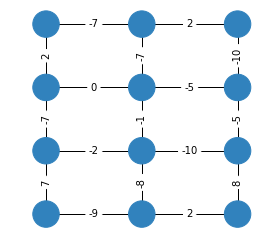

In [16]:
#define a NetworkX 4-adj connected graph
#define 'weight' of each edge to be randome integer between 1-9
G = nx.grid_2d_graph(range(3), range(4))
for u, v, d in G.edges(data = True):
    d['weight'] = np.random.randint(-10, 10)

drawing(G)

In [17]:
import time
start = time.time()
i1, i2 = 0,0
for p in partition(list(G.nodes)):
    i1+=1
    if all(is_linked(G,part) for part in p):
        i2+=1
print(i1,i2)
end = time.time()
print (end-start)

4213597 3904
19.00990104675293


min energy:  -71


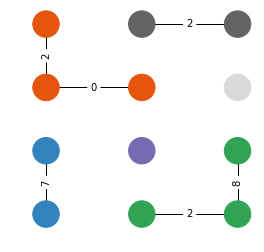

131072
14.41976022720337


In [20]:
import time
start = time.time()
minimum_energy(G)
print (t)
end = time.time()
print (end-start)